## Imports

In [1]:
import scipy.io
import numpy as np
import math
from sklearn import linear_model 
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.model_selection import KFold

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [2]:
mat = scipy.io.loadmat('sand.mat')

X = mat['X']
y = mat['Y']

[n,p] = X.shape

### 1 Apply Least angle regression and selection (LARS) for the p >> n sand data set (X: data matrix with 59 observations and 2016 features, y: the measured moisture content in percent for each sand sample). Find a suitable solution using:

>(a) The Cp statistic. Consider whether the Cp-statistic makes sense in this case (p > n). Why? Why not?

>> (i) Hint: What happens to your estimate of the noise in the data?

In [3]:
betas, res, rnk, s = linalg.lstsq(X, y)
y_ols = X@betas
# Using the mean squared error (MSE) of a low bias model (OLS) as the estimate for the noise variance
s2 = np.mean((y-y_ols)**2)  
print(s2)

1.271302484896626e-24


>(b) Using Cross-validation. Remember to center y and normalize X, but do it inside
the cross validation!

In [5]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the euclidian lenghts of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the euclidian lenghts of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the the L2 norms of the variables
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is 0 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

CV = 5 # if K = n leave-one-out, you may try different numbers

kf = KFold(n_splits=CV)
stop = n-math.ceil(n/CV)
K = range(1,stop)

Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 

# Lars
for i, (train_index, test_index) in enumerate(kf.split(X)):
    ytrain = y[train_index].ravel() # ravel collapses the array, ie dim(x,1) to (x,)
    ytest = y[test_index].ravel() 
    Xtrain = X[train_index]
    Xtest = X[test_index]

    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.    
    ytrain, mu = centerData(ytrain); # center training response
    ytest = ytest-mu; # use the mean value of the training response to center the test response
    
    Xtrain, mu = centerData(Xtrain); # center training data
    Xtest = Xtest-mu; # use the mean value of the training data to center the test data
    
    Xtrain,d = normalize(Xtrain) # normalize training data
    Xtest = Xtest / d # normalize test data using euclidian length of train data columns
    # compute all LARS solutions
    for nj,j in enumerate(K):
        reg = linear_model.Lars(n_nonzero_coefs=j, fit_path = False, fit_intercept = False, verbose = True)
        reg.fit(Xtrain,ytrain)
        beta = reg.coef_.ravel()
        
        # Predict with this model, and find error
        YhatTr = Xtrain @ beta
        YhatTest = Xtest @ beta
        
        Err_tr[i-1, nj] = np.mean((YhatTr-ytrain)**2) # training error
        Err_tst[i-1, nj] = np.mean((YhatTest-ytest)**2) # test error
        
err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

In [6]:
# Compute Cp-statistic, assumption n > p
X_norm,_ = centerData(X)
X_norm,_ = normalize(X_norm)

Betas = np.zeros((p, n))
for j in range(1,n):
    reg = linear_model.Lars(n_nonzero_coefs=j)
    reg.fit(X_norm,y)
    Betas[:,i] = reg.coef_

Cp = np.zeros((len(K)))
for j in range(len(K)):
    Yhat = X_norm @ Betas[:,K[j]]
    Cp[j] = np.mean(((y-Yhat)**2)) + 2*K[j]/n*s2

46


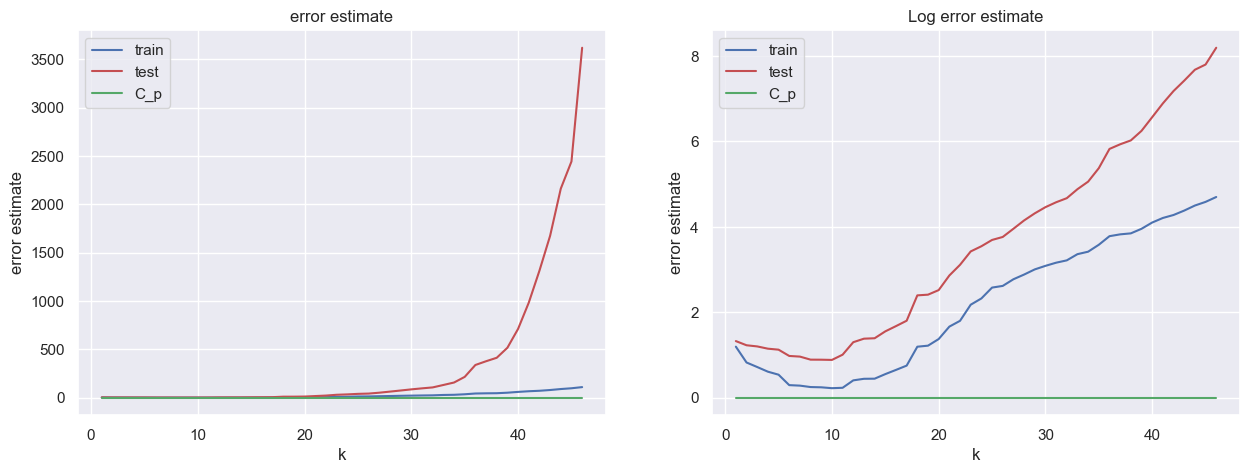

In [8]:
print(len(K))
fig, ax = plt.subplots(1,2, figsize=(15,5))    
ax[0].plot(K, err_tr, 'b', label='train')
ax[0].plot(K, err_tst, 'r', label='test')
ax[0].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('error estimate')
ax[0].set_title("error estimate")

ax[1].plot(K, np.log(err_tr), 'b', label='train')
ax[1].plot(K, np.log(err_tst), 'r', label='test')
ax[1].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('error estimate')
ax[1].set_title("Log error estimate")
plt.show()
# NOTE: Curves are flat, and minimum varies with split of data (running K-fold CV several times)
# We can use the "one-standard-error rule" to choose the optimal value of K and avoid these effects